In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, mixed_precision
from tensorflow.keras.layers import ReLU, RandomContrast, RandomTranslation, RandomFlip, RandomRotation, Input, LeakyReLU, Conv2D, Activation, MaxPool2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback
from pathlib import Path
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
import cv2 #pip install opencv-python
import numpy as np
from glob import glob 
from keras import backend as K
from contextlib import redirect_stdout
from keras.models import Model
from tensorflow.keras.applications import EfficientNetB0


PATH = 'G:/Deletar/pictures_conv'
tf.random.set_seed(42) 
PRECISION = tf.float32
HEIGHT = 224
WIDTH = 224
FILTERS = 128
KERNEL_SIZE = 3
STRIDES = 1
BATCH = 1
OUTPUT_CHANNELS = 3
BUFFER_SIZE = 1002
IMG_RANGE = 255.

""" policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy) """


train_bw = glob("G:\\Deletar\\pictures_conv\\train_new\\bw\\*.jpg")
train_color = glob("G:\\Deletar\\pictures_conv\\train_new\\color\\*.jpg")
test_bw = glob("G:\\Deletar\\pictures_conv\\test_new\\bw\\*.jpg")
test_color = glob("G:\\Deletar\\pictures_conv\\test_new\\color\\*.jpg")




In [2]:
# apply black and white colors to image
def apply_bw(filename):
    img = plt.imread(filename)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Input IMG is RGB
    img = cv2.merge([img,img,img])
    return img

def resize_image2(data):
    resized_img = tf.image.resize(
    images=K,
    size=[HEIGHT, WIDTH],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=True,
    )    
    return resized_img

def process_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, PRECISION)
    img = tf.image.resize(img, size=(HEIGHT, WIDTH))
    return img

# read img and transform into tensor image
def read_img(filename):
    img = plt.imread(filename)
    if len(img.shape) == 2:
        img = cv2.merge([img,img,img])
    img = tf.convert_to_tensor(img/IMG_RANGE, dtype=PRECISION)
    return img

def get_all_info(folder):
    imgs = []
    for file in os.listdir(folder):
        img_tensor = read_img(folder + "\\" + file) 
    return imgs

""" z = get_all_info("G:\\Deletar\\pictures_conv\\train_new\\bw") """

files_ds = tf.data.Dataset.from_tensor_slices((train_bw, train_color))
files_ds = files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH).shuffle(BUFFER_SIZE)
val_files = tf.data.Dataset.from_tensor_slices((test_bw, test_color))
val_files = val_files.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH)

example = list(files_ds.as_numpy_iterator())
example2 = list(val_files.as_numpy_iterator())



In [3]:
""" def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, padding='same', strides=2, name='conv2d_01', kernel_initializer=initializer, use_bias=False,),)                           
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result """
  
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, padding='same', strides=2, name='conv2d_01', kernel_initializer=initializer, use_bias=False,),)                           
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

""" def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result """

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=4,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result

""" result.add(MaxPool2D((2, 2),  padding='same')) """

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_test):
        self.model = model

    def on_epoch_end(self, epoch, logs={}):
      if epoch % 5 == 0: 
        z = self.model.predict(example[0][0])
        plt.imshow(z[0])
        plt.show()
        

Epoch 1/5
250/250 [==============================] - 11s 37ms/step - loss: 0.0466 - accuracy: 0.4472 - val_loss: 0.0665 - val_accuracy: 0.2624


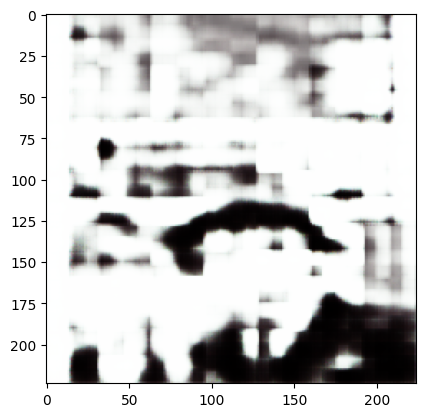

Epoch 2/5
250/250 [==============================] - 9s 36ms/step - loss: 0.0350 - accuracy: 0.4749 - val_loss: 0.0368 - val_accuracy: 0.4248
Epoch 3/5
250/250 [==============================] - 9s 36ms/step - loss: 0.0308 - accuracy: 0.4730 - val_loss: 0.0303 - val_accuracy: 0.4281
Epoch 4/5
 29/250 [==>...........................] - ETA: 6s - loss: 0.0313 - accuracy: 0.4889

KeyboardInterrupt: 

In [4]:
initializer = tf.random_normal_initializer(0., 0.02)

# improvements
# insert layer kernel_regularizer='l1'
# insert layer kernel_regularizer='l2'

# model = model = 
# model.trainable = False

""" inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))
x = inputs
x = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
x.trainable = False """

""" x = downsample(64,4, apply_batchnorm=False)(model.output) """

""" x = downsample(64,4, apply_batchnorm=False)(x)

model= x """
inputS=(HEIGHT, WIDTH, 3,)
model = Sequential()

""" model.add(Input(shape=(HEIGHT, WIDTH, 3,))) """
""" model.add(EfficientNetB0(input_shape=inputS, include_top=False, weights="imagenet")) """


""" for layer in model.layers:
  layer.trainable=False """

""" model.add(EfficientNetB0(input_shape=inputS, include_top=False, weights=None,))  """





#Encoder
""" model.add(downsample(64,4, apply_batchnorm=False))
model.add(downsample(128,4)) """

""" model.add(downsample(512,4, apply_batchnorm=False))
model.add(downsample(512,4))
model.add(downsample(512,4)) """
""" model.add(downsample(256,4, apply_batchnorm=False))
model.add(downsample(256,4)) """


""" model.add(downsample(1024,4, apply_batchnorm=False)) #best """

model.add(downsample(64,4, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(downsample(512,4))
model.add(downsample(512,4))
model.add(downsample(512,4))

#Decoder
""" model.add(upsample(512,4, apply_dropout=True))
model.add(upsample(512,4, apply_dropout=True)) """

""" model.add(upsample(256,4, apply_dropout=True)) """


""" model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh'))  """


""" model.add(Activation('tanh')) """
""" model.add(Activation('sigmoid')) """


""" model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='tanh', padding='same')) """

model.add(upsample(256,4, apply_dropout=True))
model.add(upsample(128,4))
""" model.add(upsample(64,4))
model.add(upsample(32,4)) """
""" model.add(Activation('sigmoid')) """


model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         ))

model.add(Activation('sigmoid'))

model.compile(
    # loss
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    # loss=tf.keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.MeanSquaredError(),

    # optimizer    
    #optimizer= tf.keras.optimizers.Adam(2e-3, beta_1=0.5),
    # optimizer= tf.keras.optimizers.RMSprop(),
    optimizer= tf.keras.optimizers.Adam(2e-3, beta_1=0.5),
    metrics=["accuracy"]    
)

""" callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True) """
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


model.fit(files_ds,epochs=5, callbacks=[CustomCallback(model, files_ds), callback], validation_data=val_files)


model.summary() 


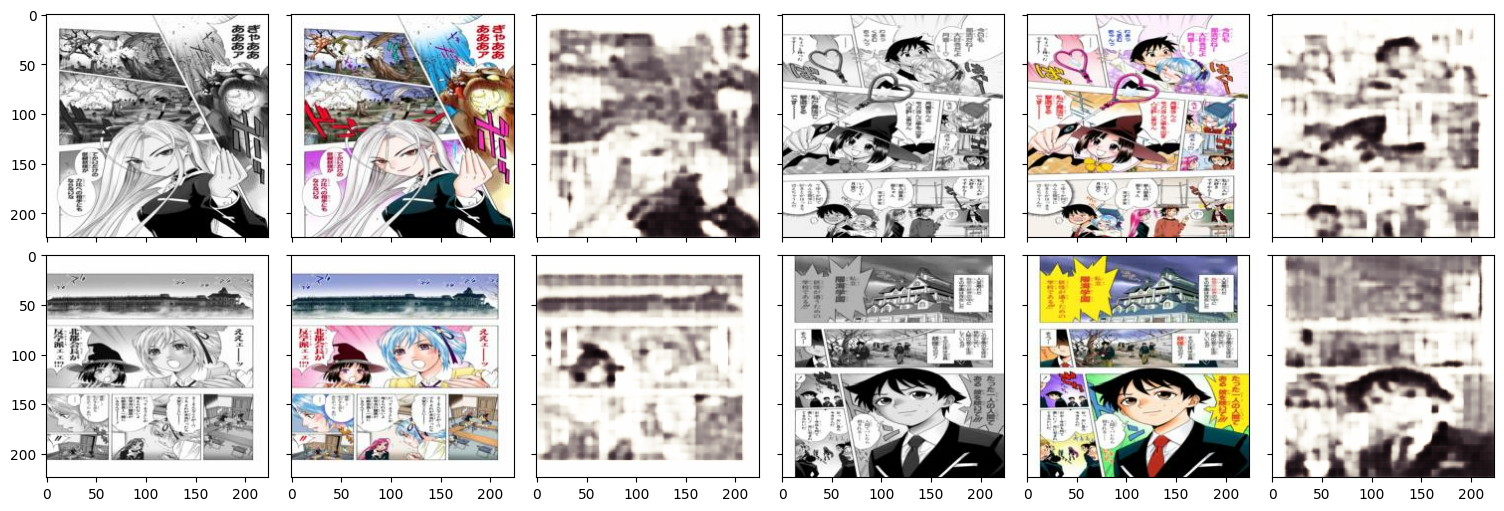

In [ ]:
test_img_pred = model.predict(example2[0][0])[0]
test_img_pred2 = model.predict(example2[1][0])[0]
test_img_pred3 = model.predict(example2[2][0])[0]
train_img_pred = model.predict(example[0][0])[0]

f, axarr = plt.subplots(2,6, figsize=(15, 5), constrained_layout=True, sharex=True, sharey=True)
axarr[0,0].imshow(example2[0][0][0])
axarr[0,1].imshow(example2[0][1][0])
axarr[0,2].imshow(test_img_pred)
axarr[0,3].imshow(example2[1][0][0])
axarr[0,4].imshow(example2[1][1][0])
axarr[0,5].imshow(test_img_pred2)

axarr[1,0].imshow(example2[2][0][0])
axarr[1,1].imshow(example2[2][1][0])
axarr[1,2].imshow(test_img_pred3)
axarr[1,3].imshow(example[0][0][0])
axarr[1,4].imshow(example[0][1][0])
axarr[1,5].imshow(train_img_pred)



In [ ]:
#comments

""" model = Sequential([
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_01'),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_01'),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_02'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_02'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_03'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_04'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_04'),
    Dropout(0.5),
    Activation('relu', name='relu_04'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_05'),
    Dropout(0.5),
    Activation('relu', name='relu_05'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_06'),
    Activation('relu', name='relu_06'),
    UpSampling2D((2, 2)),
    Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same'),
    Activation('tanh'),    
]) """

# model.add(Input(shape=[HEIGHT, WIDTH, 3]))

""" model.add(downsample(128,4, apply_batchnorm=False))
model.add(upsample(128,4, apply_dropout=True)) """

""" model = Sequential()
model.add(downsample(64,9, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(upsample(128,4, apply_dropout=True))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """

""" model.add(downsample(128,4)) """
""" model.add(downsample(256,4)) """
""" model.add(downsample(128,4, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(downsample(128,4)) """
""" model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2))) """

""" model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """


""" model.add(upsample(128,4, apply_dropout=True))
model.add(upsample(128,4, apply_dropout=True)) """
""" model.add(upsample(128,4))
model.add(upsample(128,4)) """
""" model.add(upsample(256,4, apply_dropout=True)) """
""" model.add(upsample(128,4)) """


""" 
model.add(UpSampling2D((2, 2))) """

""" encoder_output = (encoder_input)



decoder_output = (encoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output) """


' encoder_output = (encoder_input)\n\n\n\ndecoder_output = (encoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output)\ndecoder_output = (decoder_output) '